In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import ml_insights as mli
import sys
import seaborn as sns
sys.path.append('..')
import matplotlib.pyplot as plt
from scripts.export_hypers import get_hypers
from lightjob.cli import load_db
from sklearn.linear_model import LinearRegression, Lasso
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pyearth import Earth
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone
from collections import defaultdict
from IPython.display import display, Image
from tools.common import find_generation_job, to_generation
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import KFold

def squeeze(names, imp):
    group = defaultdict(float)
    for n, imp in zip(names, imp):
        group['_'.join(n.split('_')[0:-1])] += imp
    return group.keys(), group.values()

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using gpu device 0: Tesla K20Xm (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
db = load_db()
jobs = db.jobs_with(where='jobset83', state='success')
model_names = ['model64']
jobs = filter(lambda j:j['content']['model_name'] in model_names, jobs)
jobs_gen = to_generation(jobs)
filename = ['../exported_data/figs/generated/jobset00083/{}.png'.format(j['summary'])
            for j in jobs_gen]
hp = get_hypers(jobs)
#hp['filename'] = filename
#hp['id']= [j['summary'] for j in jobs]
hp.dropna(subset=['out_objectness'])
hp.to_csv('hypers.csv')

In [3]:
for nb_layers in (1, 2, 3, 4, 5):
    print('nb_layers : {}'.format(nb_layers))
    J = hp[hp['nb_layers'] == nb_layers].sample(10)
    for i in range(len(J)):
        print(J.iloc[i]['id'])
        filename = J.iloc[i]['filename']
        display(Image(filename, width=400, height=400))

nb_layers : 1


KeyError: 'id'

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

output_cols = [
    'out_objectness', 
    'out_count', 
    'out_max',
    'in_objectness', 
    'in_count', 
    'in_max'
]
data = hp.dropna(subset=output_cols, axis=0)
data_out = data.sort_values(by='out_objectness', ascending=True)#.iloc[0:100]
data_in = data.sort_values(by='in_objectness', ascending=True)#.iloc[0:100]

input_cols = list(set(data.columns) - set(output_cols))

def prep(data):
    inputs = data[input_cols]
    outputs = data[output_cols].copy()
    inputs = pd.get_dummies(inputs)
    inputs = inputs.fillna(-1)
    return inputs

x = prep(data)
y = data['out_objectness']
ind = np.arange(len(x))
np.random.shuffle(ind)
x = x.iloc[ind]
y = y.iloc[ind]
#y = data['out_objectness']> data['out_objectness'].median()
#clf = RandomForestClassifier(n_estimators=10, max_depth=100, missing_values='NaN')
#reg = GradientBoostingRegressor(n_estimators=5, max_depth=100)
#reg = RandomForestRegressor(n_estimators=100, max_depth=100)

param_dist = {"max_depth": sp_randint(10, 100),
              #"max_features": sp_randint(1, 11),
              #"min_samples_split": sp_randint(1, 11),
              #"min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(10, 100),
              "bootstrap": [True, False]}

n_iter_search = 10
reg = RandomizedSearchCV(
    RandomForestRegressor(), 
    n_jobs=-1,
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    scoring=make_scorer(r2_score),
    refit=True,
    cv=KFold(5).get_n_splits())
reg.fit(x, y)
print(reg.best_params_)
print(reg.best_score_)

{'n_estimators': 55, 'bootstrap': True, 'max_depth': 94}
0.442774018237


In [119]:
reg = reg.best_estimator_

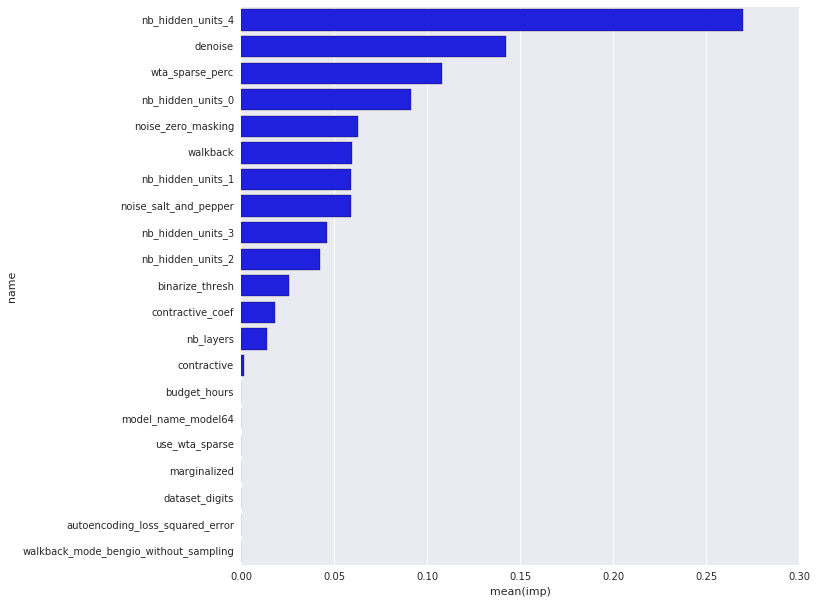

In [120]:
#df = pd.DataFrame({'name': inputs.columns, 'imp': reg.coef_})
for r in (reg,):
    df = pd.DataFrame({'name': x.columns, 'imp': r.feature_importances_})
    df['abs_imp'] = np.abs(df['imp'])
    df = df.sort_values(by='abs_imp', ascending=False)
    df = df.iloc[0:30]
    fig = plt.figure(figsize=(10, 10))
    sns.barplot(x='imp', y='name', data=df, color='blue', orient='h')
    plt.show()

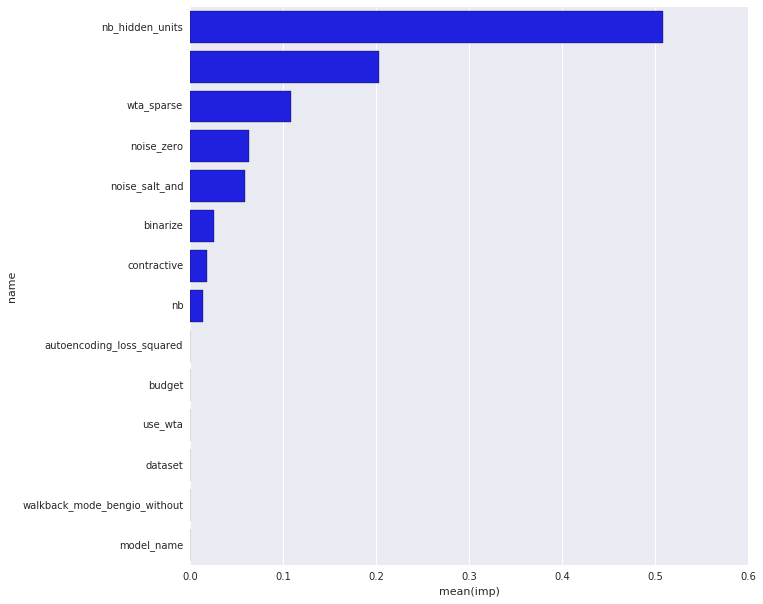

In [121]:
fig = plt.figure(figsize=(10, 10))
cols, imps = squeeze(x.columns, reg.feature_importances_)
df = pd.DataFrame({'name': cols, 'imp': imps})
df = df.sort_values(by='imp', ascending=False)
sns.barplot(x='imp', y='name', data=df, color='blue', orient='h')

## ml insights

In [122]:
mxr = mli.ModelXRay(reg, x)

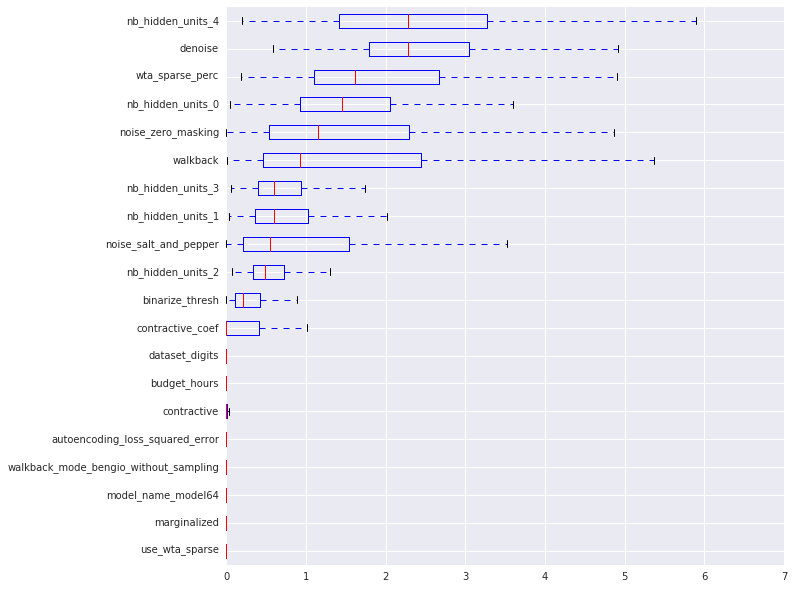

In [123]:
mxr.feature_effect_summary()

array([651,  82, 612, 267, 306])

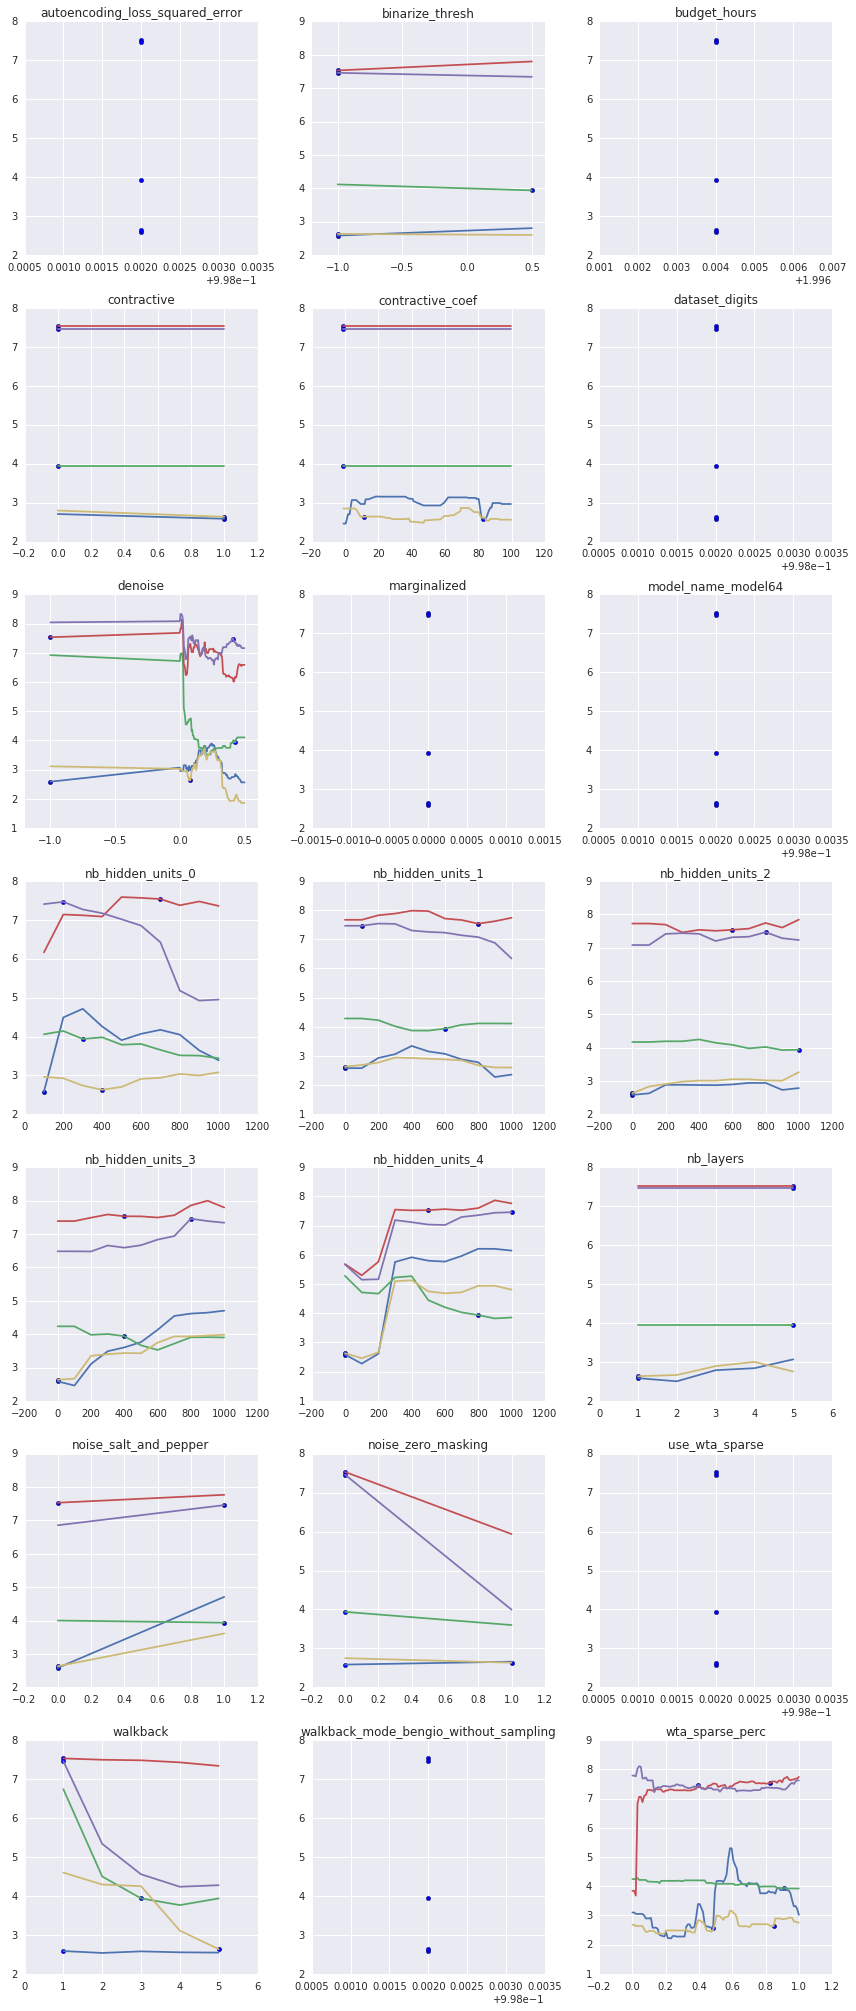

In [124]:
mxr.feature_dependence_plots(num_pts=5)

In [345]:
db = load_db()
jobs = db.jobs_with(where='jobset83', state='success')
jobs_gen = to_generation(jobs)
objectness = [db.get_value(j, 'stats.out_of_the_box_classification.fonts.sample_objectness', if_not_found=np.nan) 
              for j in jobs_gen]
count = [db.get_value(j, 'stats.out_of_the_box_classification.letterness.count_letters_95', if_not_found=np.nan) 
         for j in jobs_gen]
Max = [db.get_value(j, 'stats.out_of_the_box_classification.letterness.max_letters', if_not_found=np.nan) 
         for j in jobs_gen]
diversity = [
    2*db.get_value(j, 'stats.out_of_the_box_classification.letterness.diversity_count_letters_95', if_not_found=np.nan)-
     db.get_value(j, 'stats.out_of_the_box_classification.letterness.count_letters_95', if_not_found=np.nan)
    for j in jobs_gen
]
id_ = [j['summary'] if j else None for j in jobs_gen]
df = pd.DataFrame({'id': id_, 'objectness': objectness, 'count': count, 'diversity': diversity, 'max': Max})
df = df.dropna()

In [346]:
pd.options.display.max_rows = 2000

In [347]:
import random
from frozendict import frozendict

def pareto(x, objective):
    archive = set()
    for init in x:
        best = init
        # loop
        for i in range(100):
            found_better = False
            for m in x:
                if dominated_by(best, m, objective):
                    best = m
                    found_better = True
                    break
            if found_better and frozendict(best) not in archive:
                archive.add(frozendict(best))
                yield best
            else:
                break

                
def pareto_correct(x, objective):
    for m in x:
        dominated = False
        for n in x:
            if dominated_by(m, n, objective):
                dominated = True
                break
        if not dominated:
            yield m
            
def dominated_by(src, dst, objective):
    for k, v in objective.items():
        if objective[k] == 'max':
            cond = dst[k] > src[k]
        elif objective[k] == 'min':
            cond = dst[k] < src[k]
        if cond == False:
            return False
    return True

In [360]:
O = {'count':'max', 'diversity': 'max', 'objectness': 'max'}
P = pareto_correct(
    df.T.to_dict().values(), 
    O)
P = list(P)
for p1 in P:
    for p2 in P:
        if dominated_by(p1, p2, O) or dominated_by(p2, p1, O):
            print('No')
df = pd.DataFrame(P).sort_values(by='objectness', ascending=False)
df

,count,diversity,id,max,objectness
52,0.000,0.000000,c12e4ac30c129c9a7d20c9203e04a29d,0.000024,0.999994
61,0.000,0.000000,86255864fabd2a2467a03bf0a1a5162b,0.559172,0.999989
50,0.000,0.000000,7bfc6a3a17a5f885d338eb997cfdda26,0.559172,0.999989
68,0.000,0.000000,d0ab399adf4e35106f2c762eff0cfb72,0.675934,0.999987
66,0.000,0.000000,7c922317f8e7b57a529c8c55e36e9793,0.675935,0.999987
5,0.000,0.000000,3c533420afc54d0e5369cb7a6ae4ef1c,0.675934,0.999987
63,0.000,0.000000,e5bc0c46e7a77343a30b2a6ba8a39546,0.675935,0.999987
54,0.000,0.000000,e409caa278acf88c923e43c2e9e58abf,0.175753,0.999965
1,0.000,0.000000,3453e5869ccf13ba2af2eb5e77210955,0.664224,0.999806
51,0.000,0.000000,d301b41fc24a6cd07f1ffeb48ee8af81,0.817841,0.998797
